<a href="https://colab.research.google.com/github/ncminhbka/ML-Projects/blob/main/RNN_Financial_News_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Nhớ rằng tùy vào kiến trúc model mà tensor đầu vào (ta gọi là input) có shape và dtype khác nhau
 - Ví dụ với Embedding layer đứng đầu thì dtype torch.long, shape (BS, sqlen)
 - Với LSTM RNN đứng đầu thì dtype: torch.float32, shape: (batch_size, seq_len, input_size)

Và cũng nhớ rằng tùy hàm loss mà tensor y_train và y_pred cũng phải có shape, dtype riêng
- Với CrossEntropyLoss: y_pred (model ouput) dtype = float32,
y_true phải là torch.long. shape y_pred (BS, vocab_size), shape y_true (BS,)

DataLoader (hàm default_collate) tự động chuyển tập các giá trị thu được từ __getitem__ thành torch.Tensor khi tạo batch. Nhưng đừng dựa vào tính năng chết tiệt này, hãy cho data của bạn thành tensor ngay trong transform

In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
!gdown --id 1o09HEkDBBEjsW3gN76vDYfCAKiCqpcpg

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1o09HEkDBBEjsW3gN76vDYfCAKiCqpcpg
To: /content/financial_sentiment.zip
100% 925k/925k [00:00<00:00, 114MB/s]


In [ ]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!unzip financial_sentiment.zip

Archive:  financial_sentiment.zip
  inflating: FinancialPhraseBank/License.txt  
  inflating: FinancialPhraseBank/README.txt  
  inflating: FinancialPhraseBank/Sentences_50Agree.txt  
  inflating: FinancialPhraseBank/Sentences_66Agree.txt  
  inflating: FinancialPhraseBank/Sentences_75Agree.txt  
  inflating: FinancialPhraseBank/Sentences_AllAgree.txt  
  inflating: all-data.csv            


In [ ]:
# original file has no headers
headers = ['sentiment', 'content']
df = pd.read_csv('all-data.csv', encoding='ISO-8859-1', names=headers)
df.head()

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
#class name from neutral, negative, positive to 0 1 2
df['sentiment'] = df['sentiment'].replace({'neutral': 0, 'negative': 1, 'positive': 2})
df.head()

/tmp/ipython-input-597803233.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'neutral': 0, 'negative': 1, 'positive': 2})


,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [ ]:
df.iloc[0, 1]

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'

In [ ]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
    text = text.lower()
    text = unidecode.unidecode(text) #bỏ dấu
    text = text.strip() # cắt đầu cuối
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words]) #bỏ từ dừng
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')]) #stemming vd learning -> learn

    return text
print(text_normalize(df.iloc[2, 1]))

intern electron industri compani elcoteq laid ten employe tallinn facil  contrari earlier layoff compani contract rank offic worker  daili postime report 


In [ ]:
df['content'] = df['content'].apply(text_normalize)
df.head()

,sentiment,content
0,0,accord gran compani plan move product russia ...
1,0,technopoli plan develop stage area less 100000...
2,1,intern electron industri compani elcoteq laid ...
3,2,new product plant compani would increas capac ...
4,2,accord compani updat strategi year 20092012 b...


In [ ]:
test_size = 0.125
val_size = 0.2
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle = True
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=val_size,
    random_state=seed,
    shuffle = True
)

In [ ]:
#constructing vocab
vocab = []
for sentence in df['content'].tolist():
    for token in sentence.split(' '):
        if token not in vocab:
            vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')
print(vocab[:10])

vocab_size = len(vocab)

['accord', 'gran', '', 'compani', 'plan', 'move', 'product', 'russia', 'although', 'grow']


In [ ]:
word_to_idx = {token: idx for idx, token in enumerate(vocab)} #dict
idx_to_word = {idx: token for idx, token in enumerate(vocab)}

In [ ]:
type(word_to_idx)

dict

In [ ]:
# an input text needs to be transformed into numerical representation
def transform(text, token_to_idx, max_length):
    vector = []
    for token in text.split(' '):
        try:
            vector.append(token_to_idx[token])
        except:
            vector.append(token_to_idx['UNK'])
    if len(vector) < max_length :
        vector += [token_to_idx['PAD']] * (max_length - len(vector))
    else:
        vector = vector[:max_length]
    return vector


In [ ]:
example_text = "Alan has bought a car from Tony, he was upset because "
example_text = transform(example_text, word_to_idx, 10)
print(example_text)

[8907, 8907, 1733, 8907, 639, 8907, 8907, 8907, 8907, 8243]


In [ ]:
#turning custom dataset into pytorch dataset, we have to write a class inherits Dataset (must have 3 compulsory methods)
class FinancialNews(Dataset):
    def __init__(
        self,
        X, y,
        word_to_idx,
        max_seq_len,
        transform=None
    ):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        #khi getitem được chay (khi dataloader lấy sample) thì transform được chạy
        #transform đưa text về vector index kích thước cố định
        if self.transform:
            text = self.transform(
                text,
                self.word_to_idx,
                self.max_seq_len
            )

        text = torch.tensor(text)
        label = torch.tensor(label, dtype = torch.long)
        return text, label

In [ ]:
#create dataset
max_seq_len = 32
#X_train, y_train đang là list, X train là list chứa các string dài ngắn khác nhau
train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)
test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

In [ ]:
tensor , label = train_dataset.__getitem__(0)
print(tensor.dtype)
print(type(label))

torch.int64

In [ ]:
#create dataloader
train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [ ]:
#model
class SentimentClassifier(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim,
        hidden_size, n_layers, n_classes,
        dropout_prob
    ):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim
        )
        self.rnn = nn.RNN(input_size = embedding_dim,
                          hidden_size=hidden_size,
                          num_layers=n_layers,
                          batch_first = True
                          )
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)
    def forward(self, x):
        x = self.embedding(x)
        x, hn = self.rnn(x)
        x = x[:, -1, :] #(bs, sq_len, hidden_dim) == hn[-1, :, :] if not bidirectional -> (bs, hidden_dim)
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [ ]:
#hyper params
n_classes = 3
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob
).to(device)


In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss_batch = criterion(outputs, labels)
            loss += loss_batch.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        acc = correct/total
        loss = loss/len(dataloader)
    return loss, acc

In [ ]:
def fit(model, train_loader, val_loader, criterion, optimizer, n_epochs, device):
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loss = criterion(outputs, labels) #batch loss
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(train_loss / len(train_loader))
        acc = correct / total
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}, Train Acc: {acc}, Val Acc: {val_acc}')
    return train_losses, val_losses

In [ ]:
lr = 1e-4
epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    epochs,
    device
)

EPOCH 1:	Train loss: 24.2129	Val loss: 0.9294, Train Acc: 0.5896774193548387, Val Acc: 0.5865979381443299
EPOCH 2:	Train loss: 23.4815	Val loss: 0.9278, Train Acc: 0.59, Val Acc: 0.5855670103092784
EPOCH 3:	Train loss: 23.2652	Val loss: 0.9278, Train Acc: 0.5909677419354838, Val Acc: 0.5855670103092784
EPOCH 4:	Train loss: 23.4258	Val loss: 0.9282, Train Acc: 0.5938709677419355, Val Acc: 0.5845360824742268
EPOCH 5:	Train loss: 23.3095	Val loss: 0.9280, Train Acc: 0.5906451612903226, Val Acc: 0.5845360824742268
EPOCH 6:	Train loss: 23.2391	Val loss: 0.9291, Train Acc: 0.59, Val Acc: 0.5845360824742268
EPOCH 7:	Train loss: 23.2043	Val loss: 0.9275, Train Acc: 0.5903225806451613, Val Acc: 0.5835051546391753
EPOCH 8:	Train loss: 23.3471	Val loss: 0.9273, Train Acc: 0.5912903225806452, Val Acc: 0.5845360824742268
EPOCH 9:	Train loss: 23.2236	Val loss: 0.9272, Train Acc: 0.5916129032258064, Val Acc: 0.5845360824742268
EPOCH 10:	Train loss: 23.2626	Val loss: 0.9272, Train Acc: 0.5909677419354

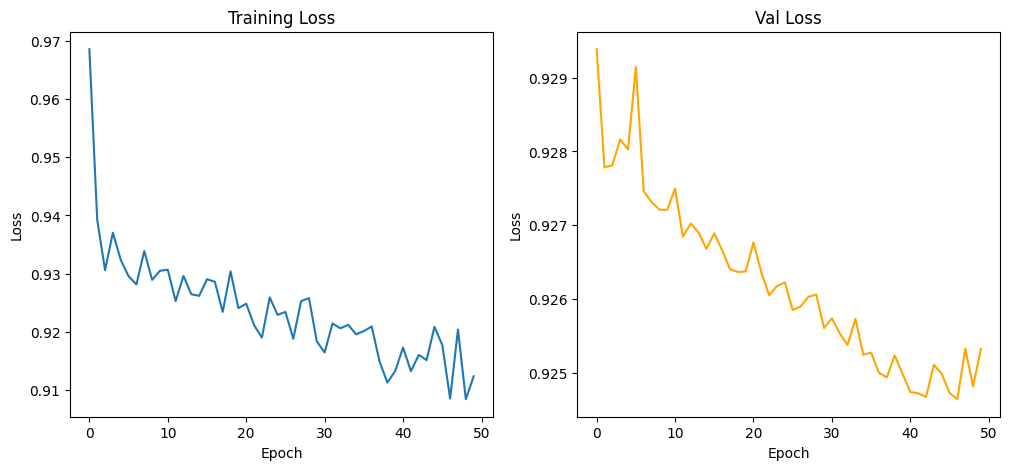

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test loss: {test_loss:.4f}\tTest Acc: {test_acc}')

Test loss: 0.9725	Test Acc: 0.5940721649484536


In [ ]:
sentence = "The company’s profits declined sharply due to higher operating costs."
sentence = text_normalize(sentence)
sentence

'compani profit declin sharpli due higher oper cost'

In [ ]:
sentence = transform(sentence, word_to_idx, max_seq_len)


In [ ]:
sentence

[3,
 58,
 848,
 8609,
 440,
 210,
 72,
 1889,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908,
 8908]

In [ ]:
sentence = torch.tensor(sentence)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(sentence.unsqueeze(0).to(device))
    _, predicted = torch.max(output.data, 1)
    print(predicted.item())
    #2 means positive 1 means neg, 0 means neutral

0
